## Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import numpy as np

## Preparing Dataframes from Datasets

### Notes

**Raw Data**
- `IL_nyt_colleges`: NYT COVID college data
- `mask`: NYT mask usage by county data
- `ipeds`: IPEDS college data
- `fips`: FIPS county codes data

**Generated Data**
- `mask_counties`: NYT mask usage by county data with county names

`IL_nyt_colleges` and `ipeds` can be joined on the `ipeds_id` column, and are both sorted by the same `ipeds_id` values from pre-code cleaning. `mask_counties` and `IL_nyt_colleges` can be joined on the `county` column.

In [35]:
# Reading in Data

'''
#ipeds_allIL_path = "../datasets/illinois/ipeds/ipedsallIL.csv"
#df_ipeds_allIL_colleges = pd.read_csv(IPEDS_allIL_path)
'''

# File Paths
IL_nyt_colleges_path = "../datasets/illinois/IL_nyt_colleges.csv"
mask_path = "../datasets/nyt/covid-19-data-master/mask-use/mask-use-by-county.csv"
ipeds_path = "../datasets/illinois/ipeds/ipeds.csv"
fips_path = "../datasets/misc/FIPS_county_codes.csv"

# Read CSVs
df_nyt_IL_colleges = pd.read_csv(IL_nyt_colleges_path)
df_mask = pd.read_csv(mask_path)
df_ipeds = pd.read_csv(ipeds_path)
df_fips = pd.read_csv(fips_path)

In [36]:
# Merging Datasets

# Add county names to mask usage via merge
df_mask_counties = pd.merge(df_mask, df_fips, left_on="COUNTYFP", right_on="FIPS")

# Remove redundant columns, rename county name column for easier use
df_mask_counties = df_mask_counties.drop(columns=["COUNTYFP"]).rename(columns={"Name": "county"})

In [37]:
# Peeking at Dataframe Heads for Reference

df_nyt_IL_colleges.head(1)

,date,state,county,city,ipeds_id,college,cases
0,12/11/20,Illinois,Rock Island,Rock Island,143084,Augustana College,134.0


In [38]:
df_mask.head(1)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444


In [39]:
df_ipeds.head(1)

,ipeds_id,institution name,year,State abbreviation,City,State abbreviation.1,ZIP code,"Tuition and fees, 2018-19","Tuition and fees, 2019-20",Institution size category,Sector of institution,Level of institution,Control of institution,Degree-granting status,Degree of urbanization,Urbanization,Enrollment
0,143084,Augustana College,2019,Illinois,Rock Island,Illinois,61201-2296,42135.0,43610.0,"1,000 - 4,999","Private not-for-profit, 4-year or above",Four or more years,Private not-for-profit,Degree-granting,City: Small,City,2607


In [40]:
df_fips.head(1)

,FIPS,Name,State
0,1001,Autauga,AL


In [41]:
df_mask_counties.head(1)

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,FIPS,county,State
0,0.053,0.074,0.134,0.295,0.444,1001,Autauga,AL


## EDA


### Cases per Capita

In [42]:
# Preparing EDA DataFrame
df_case_percapita = pd.DataFrame()

#categories I think will be useful for EDA here
df_case_percapita["cases"] = df_nyt_IL_colleges["cases"]
df_case_percapita["Enrollment"] = df_ipeds["Enrollment"]
df_case_percapita["Urbanization"] = df_ipeds["Urbanization"]
df_case_percapita["college"]= df_nyt_IL_colleges["college"]
df_case_percapita["cases per capita"] = df_case_percapita["cases"] / df_case_percapita["Enrollment"]

In [43]:
df_case_percapita.head(1)

,cases,Enrollment,Urbanization,college,cases per capita
0,134.0,2607,City,Augustana College,0.0514


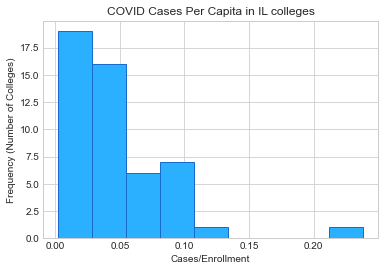

In [44]:
# Histogram of Cases Per Capita
case_percapita = df_case_percapita["cases per capita"]
case_percapita = case_percapita.dropna()

#chose bin size with Freedman-Diaconis rule: (max-min) / 2*IQR*n^(-1/3)
bin_size = (case_percapita.max() - case_percapita.min()) / (2 * st.iqr(case_percapita) * len(case_percapita) ** (-1 / 3))
bin_size = math.ceil(bin_size)

plt.style.use("seaborn-whitegrid")
plt.hist(df_case_percapita["cases per capita"], bins=bin_size, facecolor="#2ab0ff", edgecolor="#196acf")
plt.title("COVID Cases Per Capita in IL colleges")
plt.ylabel("Frequency (Number of Colleges)")
plt.xlabel("Cases/Enrollment")

plt.show()

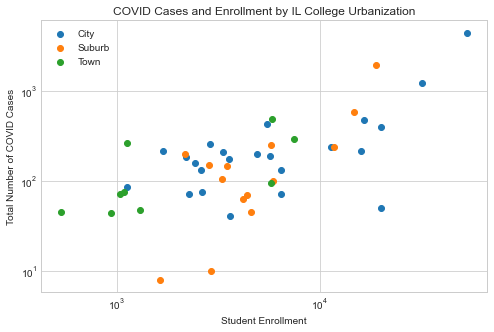

In [45]:
# Scatterplot of Cases by Enrollment and Urbanization
"""
#Add column assigning numbers to urbanization
urbanization_mapping = {"City": 3, "Suburb": 2, "Town": 1}
df_case_percapita["urban hash"] = df_case_percapita["Urbanization"].map(urbanization_mapping)
plt.figure(figsize=(8,5))

scatter_capita = plt.scatter(df_case_percapita["Enrollment"], 
                             df_case_percapita["cases"],
                             marker='o',
                             c=[i for i in df_case_percapita["urban hash"]],
                             cmap='coolwarm',
                             label=urbanization_mapping)


#Set axis to log scale
plt.xscale("log")
plt.yscale("log")
#label colorbar
plt.legend()
plt.xlabel("Enrollment")
plt.ylabel("Cases")

#cbar=plt.colorbar(scatter_capita,format=ticker.FuncFormatter())
"""

fig_scatter, ax_scatter = plt.subplots(figsize=(8, 5))

# Plot scatter for each urbanization
for urbanization in ["City", "Suburb", "Town"]:
    df_urban = df_case_percapita[df_case_percapita["Urbanization"] == urbanization]
    ax_scatter.scatter(df_urban["Enrollment"],
                       df_urban["cases"],
                       marker="o",
                       label=urbanization)

# Label plot
ax_scatter.set_title("COVID Cases and Enrollment by IL College Urbanization")
ax_scatter.set_xlabel("Student Enrollment")
ax_scatter.set_ylabel("Total Number of COVID Cases")
ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
ax_scatter.legend()

plt.show()

### Mask Usage

In [46]:
# Preparing Mask Usage EDA DataFrames

# Merging mask data with college data
df_mask_usage = pd.merge(df_nyt_IL_colleges, df_mask_counties, on="county").drop(columns=["State", "FIPS"])

# Also bringing in additional IPEDS data
df_mask_usage = pd.merge(df_mask_usage, df_ipeds, on="ipeds_id")

# Also adding the per capita data calculated earlier
df_mask_usage = pd.merge(df_mask_usage, df_case_percapita[["cases per capita", "college"]], on="college")

In [47]:
df_mask_usage.head(1)

,date,state,county,city,ipeds_id,college,cases,NEVER,RARELY,SOMETIMES,...,"Tuition and fees, 2019-20",Institution size category,Sector of institution,Level of institution,Control of institution,Degree-granting status,Degree of urbanization,Urbanization,Enrollment,cases per capita
0,12/11/20,Illinois,Rock Island,Rock Island,143084,Augustana College,134.0,0.078,0.025,0.066,...,43610.0,"1,000 - 4,999","Private not-for-profit, 4-year or above",Four or more years,Private not-for-profit,Degree-granting,City: Small,City,2607,0.0514


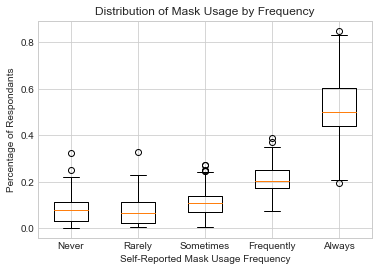

In [48]:
# Box Plot of Usage Distributions

# Preparing data
data = [df_mask_usage["NEVER"],
        df_mask_usage["RARELY"],
        df_mask_usage["SOMETIMES"],
        df_mask_usage["FREQUENTLY"],
        df_mask_usage["ALWAYS"]]

fig_box, ax_box = plt.subplots()

ax_box.boxplot(data,
            labels=["Never", "Rarely", "Sometimes", "Frequently", "Always"])
ax_box.set_xlabel("Self-Reported Mask Usage Frequency")
ax_box.set_ylabel("Percentage of Respondants")
ax_box.set_title("Distribution of Mask Usage by Frequency")

plt.show()

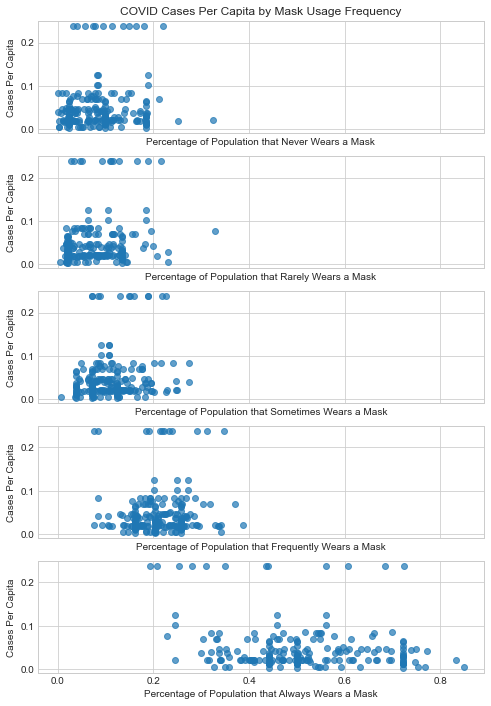

In [49]:
# Multiple Scatterplots of Usage vs Per Capita Cases

fig_scatter2, ax_scatter2 = plt.subplots(5, sharex=True, figsize=(8, 12))

# For labels
frequency_name_map = {"NEVER": "Never",
                      "RARELY": "Rarely",
                      "SOMETIMES": "Sometimes",
                      "FREQUENTLY": "Frequently",
                      "ALWAYS": "Always"}

#
for i, freq in enumerate(["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]):
    ax_scatter2[i].scatter(df_mask_usage[freq],
                           df_mask_usage["cases per capita"],
                           marker="o",
                           alpha=0.7,
                           label=frequency_name_map[freq])
    ax_scatter2[i].set_ylabel("Cases Per Capita")
    ax_scatter2[i].set_xlabel("Percentage of Population that " + frequency_name_map[freq] + " Wears a Mask")

ax_scatter2[0].set_title("COVID Cases Per Capita by Mask Usage Frequency")

plt.show()

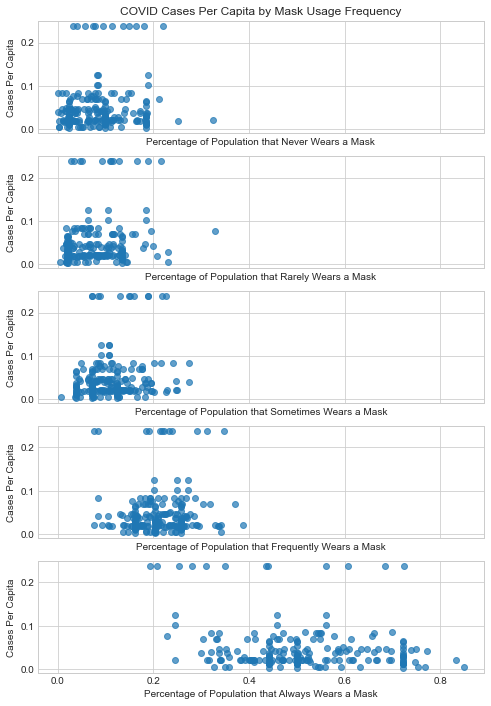

In [50]:
# Multiple Scatterplots of Usage vs Per Capita Cases

fig_scatter2, ax_scatter2 = plt.subplots(5, sharex=True, figsize=(8, 12))

# For labels
frequency_name_map = {"NEVER": "Never",
                      "RARELY": "Rarely",
                      "SOMETIMES": "Sometimes",
                      "FREQUENTLY": "Frequently",
                      "ALWAYS": "Always"}

#
for i, freq in enumerate(["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]):
    ax_scatter2[i].scatter(df_mask_usage[freq],
                           df_mask_usage["cases per capita"],
                           marker="o",
                           alpha=0.7,
                           label=frequency_name_map[freq])
    ax_scatter2[i].set_ylabel("Cases Per Capita")
    ax_scatter2[i].set_xlabel("Percentage of Population that " + frequency_name_map[freq] + " Wears a Mask")

ax_scatter2[0].set_title("COVID Cases Per Capita by Mask Usage Frequency")

plt.show()

In [51]:
df_ipeds.head(1)

,ipeds_id,institution name,year,State abbreviation,City,State abbreviation.1,ZIP code,"Tuition and fees, 2018-19","Tuition and fees, 2019-20",Institution size category,Sector of institution,Level of institution,Control of institution,Degree-granting status,Degree of urbanization,Urbanization,Enrollment
0,143084,Augustana College,2019,Illinois,Rock Island,Illinois,61201-2296,42135.0,43610.0,"1,000 - 4,999","Private not-for-profit, 4-year or above",Four or more years,Private not-for-profit,Degree-granting,City: Small,City,2607


In [52]:
df_fips.head(1)

,FIPS,Name,State
0,1001,Autauga,AL


In [53]:
df_mask_counties.head(1)

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,FIPS,county,State
0,0.053,0.074,0.134,0.295,0.444,1001,Autauga,AL


## EDA


### Cases per Capita

In [54]:
# Preparing EDA DataFrame
df_case_percapita = pd.DataFrame()

#categories I think will be useful for EDA here
df_case_percapita["cases"] = df_nyt_IL_colleges["cases"]
df_case_percapita["Enrollment"] = df_ipeds["Enrollment"]
df_case_percapita["Urbanization"] = df_ipeds["Urbanization"]
df_case_percapita["college"]= df_nyt_IL_colleges["college"]
df_case_percapita["cases per capita"] = df_case_percapita["cases"] / df_case_percapita["Enrollment"]

In [55]:
df_case_percapita.head(1)

,cases,Enrollment,Urbanization,college,cases per capita
0,134.0,2607,City,Augustana College,0.0514


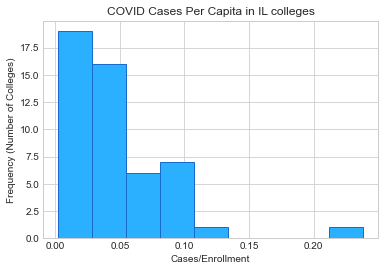

In [56]:
# Histogram of Cases Per Capita
case_percapita = df_case_percapita["cases per capita"]
case_percapita = case_percapita.dropna()

#chose bin size with Freedman-Diaconis rule: (max-min) / 2*IQR*n^(-1/3)
bin_size = (case_percapita.max() - case_percapita.min()) / (2 * st.iqr(case_percapita) * len(case_percapita) ** (-1 / 3))
bin_size = math.ceil(bin_size)

plt.style.use("seaborn-whitegrid")
plt.hist(df_case_percapita["cases per capita"], bins=bin_size, facecolor="#2ab0ff", edgecolor="#196acf")
plt.title("COVID Cases Per Capita in IL colleges")
plt.ylabel("Frequency (Number of Colleges)")
plt.xlabel("Cases/Enrollment")

plt.show()

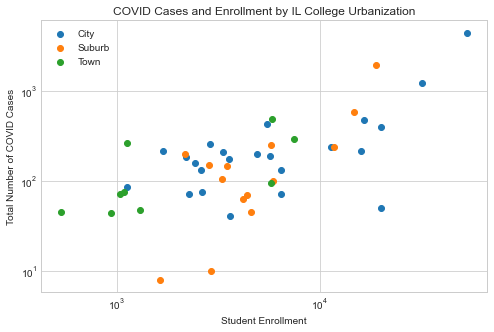

In [57]:
# Scatterplot of Cases by Enrollment and Urbanization
"""
#Add column assigning numbers to urbanization
urbanization_mapping = {"City": 3, "Suburb": 2, "Town": 1}
df_case_percapita["urban hash"] = df_case_percapita["Urbanization"].map(urbanization_mapping)
plt.figure(figsize=(8,5))

scatter_capita = plt.scatter(df_case_percapita["Enrollment"], 
                             df_case_percapita["cases"],
                             marker='o',
                             c=[i for i in df_case_percapita["urban hash"]],
                             cmap='coolwarm',
                             label=urbanization_mapping)


#Set axis to log scale
plt.xscale("log")
plt.yscale("log")
#label colorbar
plt.legend()
plt.xlabel("Enrollment")
plt.ylabel("Cases")

#cbar=plt.colorbar(scatter_capita,format=ticker.FuncFormatter())
"""

fig_scatter, ax_scatter = plt.subplots(figsize=(8, 5))

# Plot scatter for each urbanization
for urbanization in ["City", "Suburb", "Town"]:
    df_urban = df_case_percapita[df_case_percapita["Urbanization"] == urbanization]
    ax_scatter.scatter(df_urban["Enrollment"],
                       df_urban["cases"],
                       marker="o",
                       label=urbanization)

# Label plot
ax_scatter.set_title("COVID Cases and Enrollment by IL College Urbanization")
ax_scatter.set_xlabel("Student Enrollment")
ax_scatter.set_ylabel("Total Number of COVID Cases")
ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
ax_scatter.legend()

plt.show()

### Mask Usage

In [58]:
# Preparing Mask Usage EDA DataFrames

# Merging mask data with college data
df_mask_usage = pd.merge(df_nyt_IL_colleges, df_mask_counties, on="county").drop(columns=["State", "FIPS"])

# Also bringing in additional IPEDS data
df_mask_usage = pd.merge(df_mask_usage, df_ipeds, on="ipeds_id")

# Also adding the per capita data calculated earlier
df_mask_usage = pd.merge(df_mask_usage, df_case_percapita[["cases per capita", "college"]], on="college")

In [59]:
df_mask_usage.head(1)

,date,state,county,city,ipeds_id,college,cases,NEVER,RARELY,SOMETIMES,...,"Tuition and fees, 2019-20",Institution size category,Sector of institution,Level of institution,Control of institution,Degree-granting status,Degree of urbanization,Urbanization,Enrollment,cases per capita
0,12/11/20,Illinois,Rock Island,Rock Island,143084,Augustana College,134.0,0.078,0.025,0.066,...,43610.0,"1,000 - 4,999","Private not-for-profit, 4-year or above",Four or more years,Private not-for-profit,Degree-granting,City: Small,City,2607,0.0514


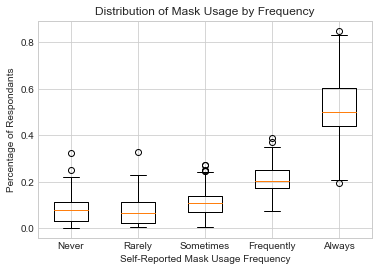

In [60]:
# Box Plot of Usage Distributions

# Preparing data
data = [df_mask_usage["NEVER"],
        df_mask_usage["RARELY"],
        df_mask_usage["SOMETIMES"],
        df_mask_usage["FREQUENTLY"],
        df_mask_usage["ALWAYS"]]

fig_box, ax_box = plt.subplots()

ax_box.boxplot(data,
            labels=["Never", "Rarely", "Sometimes", "Frequently", "Always"])
ax_box.set_xlabel("Self-Reported Mask Usage Frequency")
ax_box.set_ylabel("Percentage of Respondants")
ax_box.set_title("Distribution of Mask Usage by Frequency")

plt.show()

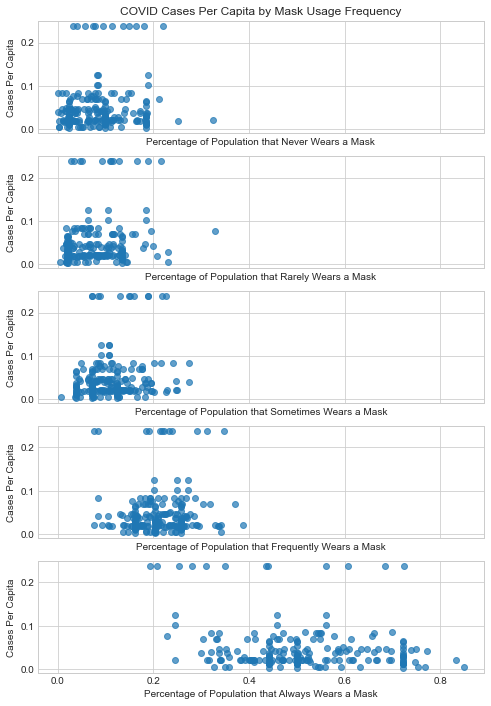

In [61]:
# Multiple Scatterplots of Usage vs Per Capita Cases

fig_scatter2, ax_scatter2 = plt.subplots(5, sharex=True, figsize=(8, 12))

# For labels
frequency_name_map = {"NEVER": "Never",
                      "RARELY": "Rarely",
                      "SOMETIMES": "Sometimes",
                      "FREQUENTLY": "Frequently",
                      "ALWAYS": "Always"}

#
for i, freq in enumerate(["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]):
    ax_scatter2[i].scatter(df_mask_usage[freq],
                           df_mask_usage["cases per capita"],
                           marker="o",
                           alpha=0.7,
                           label=frequency_name_map[freq])
    ax_scatter2[i].set_ylabel("Cases Per Capita")
    ax_scatter2[i].set_xlabel("Percentage of Population that " + frequency_name_map[freq] + " Wears a Mask")

ax_scatter2[0].set_title("COVID Cases Per Capita by Mask Usage Frequency")

plt.show()

### Linear SVM

Prepare target where cases per capita > 0.1

In [62]:
train_percapita =[i > .1 for i in case_percapita]

### Prepare features
'mask used always' 'urbanization' 'enrollment'

In [63]:
df_mask_urban_enroll = df_mask_usage[["ALWAYS"]]
df_mask_urban_enroll = df_case_percapita[["Urbanization"]]
df_mask_urban_enroll= df_mask_urban_enroll.join(df_case_percapita["Enrollment"])

Search for best parameters

In [64]:
parameters={'C':[200,300,400,500,1000],'penalty':['l1','l2'],'tol':[1e-2,1e-3,1e-4,1e-5]}
